# Assignment Description:

---


Assignment Page: https://sites.google.com/site/ucsdcogs181fall2017/classroom-news

Due date: 11:59Pm, 12/16

Late Policy: 5% of the total points will be deducted for the first day past due and every 10% of the total points will be deducted for every extra day afterwards.

Report format: Write a report with >1,500 words including main sections: a) abstract, b) introduction, c) method, d) experiment, e) conclusion, and f) references. You can follow the paper format as e.g leading machine learning journals such as Journal of Machine Learning Research (http://www.jmlr.org/) or IEEE Trans. on Pattern Analysis and Machine Intelligence (http://www.computer.org/web/tpami), or leading conferences like NIPS (https://papers.nips.cc/) and ICML (http://icml.cc/2016/?page_id=151). 

Bonus points: If you feel that your work deserves bonus points due to reasons such as: a) novel ideas and applications, b) large efforts in your own data collection/preparation, c) state-of-the-art results on your applications, or d) new algorithms or neural network architecture, please create a "Bonus Points" section to specifically describe why you deserve bonus points. In general, we evaluation your justifications based on the review guidelines based on e.g. CVPR/NIPS/ICCV/ICLR.


Note that  requirement for the word count (>1,500)  only applies to a single-student project. For team-based projects, each team only needs to write one final report but the role of each team member needs to be clearly defined ans specified. The final project report is also supposed to be much longer thatn 1,500 words, depending upon how many (maximum 3) members there are in your team.

Word count:
One-person team: >1,500
Two-persons team: > 2,200
Three-persons team: > 2,900

See below a link about writing a scientific paper: http://abacus.bates.edu/~ganderso/biology/resources/writing/HTWtoc.html The format of your references can be of any kind that is adopted in the above journals or conferences.

Grading: The merit and grading of your project can be judged from aspects described below that are common when reviewing a paper: 
1. Interestingness of the problem you are studying. (10 points).

2. How challenging and large is the dataset you are studying? (10 points)

3. Any aspects that are new in terms of algorithm development, uniqueness of the data, or new applications? (20 points)

4. Is your experimental design comprehensive? Have you done thoroughly experiments in tuning hyper parameters? (30 points)

Tuning hyper-parameters in your final project will need to be more comprehensive that what was done in HW4.
For example, if you are performing CNN classification on the Tiny ImageNet dataset, some options to consider include
a. Comparing two different architectures chosen from e.g. LeNet, AlexNet, VGG, GoogleNet or ResNet
b. Trying to vary the number of layers.
c. Trying to adopt different optimization methods, for example Adam vs. stocahstic gradient descent
d. Trying different pooling functions, average pooling, max pooling, stochastic pooling
e. Trying to use different activation functions such as ReLu, Sigmoid etc.
 
See e.g. how the significance was justified in the ResNet pape (you don't have to follow this paper though): https://arxiv.org/pdf/1512.03385.pdf
 
5. Is your report written in a professional way with sections including abstract, introduction, method/architecture description, experiments ( data and problem description, hyper-parameters, training process etc.), conclusion, and references? (30 points)

6. Bonus points will be assigned to projects that have adopted new methods, worked on novel applications, and/or have done a thorough comparison against the existing methods and possible choices.


### Option (1): Convolutional neural networks Train a convolutional neural networks method on Tiny ImageNet dataset 
    Link : http://pages.ucsd.edu/~ztu/courses/tiny-imagenet-200.zip)

You can choose any deep learning platforms including MatConvNet (http://www.vlfeat.org/matconvnet/), Theano (http://deeplearning.net/software/theano/), Torch (http://torch.ch/), Caffe (http://caffe.berkeleyvision.org/), MxNet (https://github.com/dmlc/mxnet), and TensorFlow.

See in the link other possible platforms you can use: http://deeplearning.net/software_links/ You can train a model by building your own network structure or by adopting/following standard networks like AlexNet, GoogLeNet, VGG, etc. You are also welcome to use datasets other than ImageNet, e.g. CIFAR-10, and Kaggle datasets (https://www.kaggle.com/) such as the deep sea image competition: https://www.kaggle.com/c/datasciencebowl

### Data source and Related Paper
- https://tiny-imagenet.herokuapp.com/
- http://cs231n.stanford.edu/reports/2017/pdfs/937.pdf
- http://cs231n.stanford.edu/reports/2017/pdfs/940.pdf

# Setup, Download and Preprocess

In [2]:
# To determine which version you're using:
!pip show tensorflow-gpu
!pip show keras

Name: tensorflow-gpu
Version: 1.4.0.dev20171012
Summary: TensorFlow helps the tensors flow
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /opt/conda/lib/python2.7/site-packages
Requires: enum34, backports.weakref, wheel, mock, tensorflow-tensorboard, numpy, protobuf, six
Name: Keras
Version: 2.0.8
Summary: Deep Learning for Python
Home-page: https://github.com/fchollet/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /opt/conda/lib/python2.7/site-packages
Requires: pyyaml, six, scipy, numpy


In [1]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
  
get_available_gpus()

[u'/device:GPU:0']

In [2]:
!cd /tmp; wget --quiet http://pages.ucsd.edu/~ztu/courses/tiny-imagenet-200.zip
!cd /tmp; unzip -qq tiny-imagenet-200.zip; rm tiny-imagenet-200.zip

### Imports

In [3]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import random
import scipy.ndimage
import pandas as pd
import numpy as np
from collections import defaultdict
from PIL import Image
from tensorflow.contrib.learn.python.learn.datasets.mnist import DataSet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

def distort(filename):
    """Apply image distortions"""
    with tf.Graph().as_default():
        file = tf.read_file(filename)
        img = tf.image.decode_jpeg(file, 3)
        img = tf.image.adjust_saturation(img, 0.5)
        img = tf.image.adjust_hue(img, -0.05)
        with tf.Session() as sess:
            dist_img = sess.run(img)
    
    return dist_img

### Data Exploratory

In [4]:
import glob

path = "/tmp/tiny-imagenet-200/"
train_dirs = glob.glob(path + "train/*")
val_dirs   = glob.glob(path + "val/*")
test_dirs  = glob.glob(path + "test/*")

#### Loading All Labels

In [5]:
# This is global labels, there are 18K of them, but only 200 is used for training and validation
labels = []
for line in open(path + 'words.txt'):
    [classname, description ] = line.strip().split('\t')
    labels.append( (classname,description) )
label_dicts = dict(labels)

# There are only 200 used labels in both training and validation
used_labels =  [ d[-9:] for d in train_dirs ]
len(used_labels)

# Hot-Encode Labels
from sklearn.preprocessing import LabelBinarizer

bin_encoder = LabelBinarizer()
bin_encoder.fit_transform(used_labels).size

40000

#### Loading Train Data

In [6]:
train_data_paths = []
train_labels = []
for class_path in train_dirs:
    class_name = class_path[-9:]
    images = glob.glob(class_path + '/images/*')
    for image_path in images:
        train_labels.append( class_name )
        train_data_paths.append( image_path )
        
inter = list(zip(train_data_paths, train_labels))
random.shuffle(inter)
train_data_paths, train_labels = zip(*inter)

train_labels = bin_encoder.transform(train_labels) # hot-encode labels from string to number
len(train_labels)

100000

In [7]:
def get_image(img_path):
    img = scipy.ndimage.imread(img_path)
    if len(img.shape) != 3: # reshape back to RBG format
        img = np.repeat(img[:,:,np.newaxis], 3, axis=2)
    return img

def get_images(paths):
    X = []
    for p in paths:
        X.append(get_image(p))
    return X
        
def prepare_batch(X,y,batch_size=50):
    N = len(y) / batch_size
    i = 0
    yield X[:batch_size], y[:batch_size]
    while i < N:
        yield X[batch_size*i:batch_size*(i+1)], y[batch_size*i:batch_size*(i+1)]
        i = i + 1

In [12]:
# inter = list(zip(train_images, train_labels))
# random.shuffle(inter)
# images, labels = zip(*inter)
# train_data = DataSet( np.array(train_images), np.array(train_labels), reshape=False)
# del train_images, train_labels

### Loading Validation Data

In [8]:
val_labels = []
val_fns = []
val_images = []
for line in open(path + 'val/val_annotations.txt'):
  [fn, classname, _ , _, _, _ ] = line.strip().split('\t')
  
  img = scipy.ndimage.imread(path +'val/images/' + fn )
  if len(img.shape) != 3: # reshape back to RBG format
      img = np.repeat(img[:,:,np.newaxis], 3, axis=2)
      
  val_labels.append(classname)
  val_images.append(img)

# hot-encode labels from string to number
# val_labels = encoder.transform(val_labels)
val_labels = bin_encoder.transform(val_labels)

val_data = DataSet( np.array(val_images), np.array(val_labels), reshape=False)
del val_labels, val_images
val_data.num_examples

10000

In [9]:
# mini-validation set
_x_val, _y_val = val_data.next_batch(2000)
_x_val.shape, _y_val.shape

((2000, 64, 64, 3), (2000, 200))

In [23]:
get_image(train_data_paths[0]) / 255.0

array([[[ 0.34509804,  0.29411765,  0.12156863],
        [ 0.34117647,  0.28235294,  0.11372549],
        [ 0.32941176,  0.2745098 ,  0.09803922],
        ..., 
        [ 0.30980392,  0.25882353,  0.09411765],
        [ 0.32941176,  0.27843137,  0.11372549],
        [ 0.34117647,  0.28627451,  0.13333333]],

       [[ 0.35294118,  0.30196078,  0.12941176],
        [ 0.34901961,  0.29019608,  0.12156863],
        [ 0.3372549 ,  0.28235294,  0.10588235],
        ..., 
        [ 0.31372549,  0.2627451 ,  0.09803922],
        [ 0.33333333,  0.28235294,  0.11764706],
        [ 0.34509804,  0.29411765,  0.12941176]],

       [[ 0.36078431,  0.30980392,  0.1372549 ],
        [ 0.35686275,  0.29803922,  0.12941176],
        [ 0.34509804,  0.29019608,  0.11372549],
        ..., 
        [ 0.31764706,  0.26666667,  0.10196078],
        [ 0.3372549 ,  0.28627451,  0.12156863],
        [ 0.34901961,  0.29803922,  0.13333333]],

       ..., 
       [[ 0.27058824,  0.25098039,  0.1254902 ],
        

# Data Analysis

In [10]:

# Network Parameters
n_classes = 200

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pooling2d(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

X = tf.placeholder("float", [None, 64, 64, 3], name='x')
Y = tf.placeholder("float", [None, n_classes], name='y_true')

In [11]:
class ConvNet():
    
    def __init__(self, conv_fn, pooling_fn, activation_fn):
        self._conv_fn = conv_fn
        self._pooling_fn = pooling_fn
        self._activation_fn = activation_fn
    
    def conv_layer(self, x, n_filters, kernel_size):
        shape = [kernel_size] * 2
        shape = shape + [x.shape[-1].value, n_filters]
        
        w = weight_variable(shape)
        b = bias_variable([n_filters])
        return self._activation_fn(self._conv_fn(x, w) + b)
    
    def pool_layer(self, x, n_strides, kernel_size):
        return self._pooling_fn(x)
    
    def fc_layer(self, x, n_neurons):
        mult = lambda x, y: x * y
        
        shape = x.get_shape().as_list()[1:]
        flat_shape = reduce(mult, shape, 1)
        
        w = weight_variable([flat_shape, n_neurons])
        b = bias_variable([n_neurons])
        x_flat = tf.reshape(x, [-1, flat_shape])
        fc = self._activation_fn(tf.matmul(x_flat, w) + b)
        return fc
    
    def out_layer(self, x, n_classes):
        w = weight_variable([x.shape[-1].value, n_classes])
        b = bias_variable([n_classes])
        return tf.matmul(x, w) + b

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py

In [12]:
learning_rate = 1e-4

# Convolutions use a stride of one
# Plain old max pooling over 2x2 blocks
# Activation function is the ReLu function
conv_net = ConvNet(conv2d, max_pooling2d, tf.nn.relu)

# MNIST data input is a 1-D vector of 784 features (28*28 pixels)
# Reshape to match picture format [Height x Width x Channel]
x_image = tf.reshape(X, [-1, 64, 64, 3], name='X')

# Convolution Layer with 32 filters and a kernel size of 5
conv1 = conv_net.conv_layer(x_image, 32, 5)

# Convolution Layer with 64 filters and a kernel size of 5
conv2 = conv_net.conv_layer(conv1, 64, 5)

# Fully connected layer with 1024 neurons
fc = conv_net.fc_layer(conv2, 1024)

# Applying a dropout before the readout layer to reduce
# overfitting
keep_prob = tf.placeholder(tf.float32)
fc = tf.nn.dropout(fc, keep_prob)

# Readout layer
y_conv = conv_net.out_layer(fc, n_classes)

In [13]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=Y))
optimizer     = tf.train.AdamOptimizer(learning_rate)
train_step    = optimizer.minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(Y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


train_loss,train_acc  = [],[]
val_acc   , test_acc  = [],[]

In [ ]:
# Training Parameters
epoch = 15             # two pass on all training_data
batch_size = 25        # in each iteration, train 50, total iteration = 100K / batch_size (in the case of 25 batch size, 4K iteration)

# Use interactive session instead
# with tf.Session() as sess:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
i = 0
for e in range(epoch):
    for img_paths, batch_y in prepare_batch(train_data_paths, train_labels, batch_size=batch_size):
        batch_x = get_images(img_paths)
        _, loss = sess.run([train_step, cross_entropy], feed_dict={X: batch_x, Y: batch_y, keep_prob: 0.5})
        train_accuracy = accuracy.eval(session=sess, feed_dict={X: batch_x, Y: batch_y, keep_prob: 1.0})
        train_acc.append(train_accuracy)
        
#         val_accuracy   = accuracy.eval(session=sess, feed_dict={X: _x_val, Y: _y_val  , keep_prob: 1.0}) # mini-validation sample, because not enough memory
#         val_acc  .append(val_accuracy)

        train_loss.append(loss)
        i += 1
        if i % 2000 == 0:
            print('step %d, training accuracy %g' % (i, train_accuracy))

step 2000, training accuracy 0
step 4000, training accuracy 0
step 6000, training accuracy 0
step 8000, training accuracy 0
step 10000, training accuracy 0
step 12000, training accuracy 0
step 14000, training accuracy 0
step 16000, training accuracy 0
step 18000, training accuracy 0
step 20000, training accuracy 0
step 22000, training accuracy 0
step 24000, training accuracy 0
step 26000, training accuracy 0
step 28000, training accuracy 0


In [26]:
print('val accuracy %g' % accuracy.eval(session=sess, feed_dict={ X: val_data.images[:1000], Y: val_data.labels[:1000], keep_prob: 1.0}))
for i in range(9):
    print('val accuracy %g' % accuracy.eval(session=sess, feed_dict={ X: val_data.images[ i*1000 : (i+1)*1000 ], Y: val_data.labels[ i*1000:(i+1)*1000], keep_prob: 1.0}))

val accuracy 0.025
val accuracy 0.025
val accuracy 0.032
val accuracy 0.031
val accuracy 0.022
val accuracy 0.033
val accuracy 0.021
val accuracy 0.025
val accuracy 0.018
val accuracy 0.027


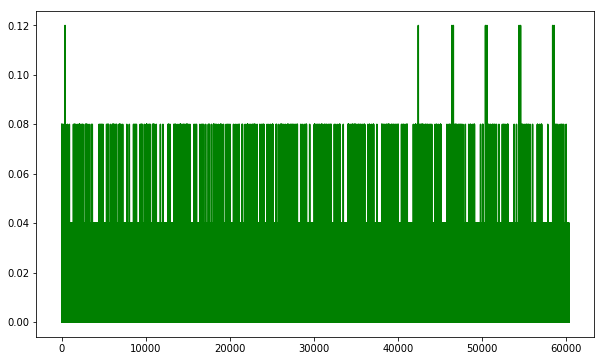

In [18]:
plt.plot(train_acc, color='g')
# plt.plot(val_acc  , color='r')
plt.show()

In [15]:
sess.close()